In [1]:
# Import dependencies
%matplotlib inline
import numpy as np
np.random.seed(42) # fixing the seed
import matplotlib
import matplotlib.pyplot as plt
import rampy as rp
import scipy
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker
from scipy.signal import find_peaks, peak_widths
import pathlib
import seaborn as sns

# Snivy color scheme
snivy = ['#F4D638', '#5AB355', '#1F766D', '#F1F0B8', '#9C413E']
venusaur = ['#3F9490', '#7BB7B7', '#E86E7F', '#EAC787', '#5F9569']
# Colors
ptcolors = ['#ed1c24', '#015798']

In [2]:
# LOD threshold
LODt = 1.5


def processTrace(filename, frameRate=1): 
    df = pd.read_csv(filename)
    df['Time'] = df['[sec]']/frameRate
    df['Index'] = np.asfarray(range(0, len(df)))
    
    # Normalize to initial fluorescence
    df['F0'] = df['Mean']/df['Mean'][0]
    df['F0'] = np.subtract(df['F0'], df['F0'][0])
    df['F0'] = np.subtract(df['F0'], min(df['F0']))
    return df

def processTrace2(filename, frameRate=0.94): 
    df = pd.read_csv(filename)
    df['Time'] = df['Slice']/frameRate
    
    # Normalize to initial fluorescence
    df['F0'] = df['Mean']/df['Mean'][0]
    df['F0'] = np.subtract(df['F0'], df['F0'][0])
    df['F0'] = np.subtract(df['F0'], min(df['F0']))
    return df

def peakMaker(x, y):
    # SciPy Peaks
    slices = x
    pky = y
    peaks, properties = find_peaks(pky, height=0.3, distance=1, width=0.5)
    peak_count = len(peaks)
    pkFrames = slices[peaks]
    # print(pkFrames)
    
    # Others
    add_pks = []
    for i in range(1, len(slices)):
        if y[i] > y[i-1]*LODt:
            add_pks = np.append(add_pks, slices[i])
    z = np.concatenate((pkFrames, add_pks))
    _, i = np.unique(z, return_index=True)
    pk = z[np.sort(i)]
    return pk


def peakMakerLOD_withAdj(x, y): 
    slices = x
    pky = y
    # Others
    add_pks = []
    indexes = []
    for i in range(1, len(slices)):
        if pky[i] > pky[i-1]*LODt:
            if pky[i] > 0.05:
                add_pks = np.append(add_pks, slices[i])
    pk = add_pks
    return pk

def peakMakerLOD(x, y): 
    slices = x
    pky = y
    # Others
    add_pks = []
    indexes = []
    for i in range(1, len(slices)):
        if pky[i] > pky[i-1]*LODt:
            if pky[i] > 0.05:
                add_pks = np.append(add_pks, slices[i])
    pk = []
    
    # Exclude adjacent detected peaks
    for i in range(1, len(add_pks)):
        if add_pks[i] < add_pks[i-1]+5:
            continue
        else: 
            pk = np.append(pk, add_pks[i])
    return pk


def peakMaker2(x, y):
    # SciPy Peaks
    slices = x
    pky = y
    peaks, properties = find_peaks(pky, height=0.3, distance=1, width=0.5)
    peak_count = len(peaks)
    pkFrames = slices[peaks]
    # print(pkFrames)
    
    # Others
    add_pks = []
    # for i in range(1, len(slices)):
        # if y[i] > y[i-1]*LODt:
            # add_pks = np.append(add_pks, slices[i])
    z = np.concatenate((pkFrames, add_pks))
    _, i = np.unique(z, return_index=True)
    pk = z[np.sort(i)]
    return pk, peaks
    
def diffMaker(pk, stimFrames): 
    master_diffs = np.asfarray([])
    for i in range(0, len(pk)): 
        diffs = np.subtract(stimFrames, pk[i])
        diffs = np.multiply(diffs, -1)
        abs_diffs = abs(diffs)
        abs_diff = min(abs_diffs)
        min_index = np.where(abs_diffs == abs_diff)
        diff = diffs[min_index]
        master_diffs = np.append(master_diffs, diff)
    return(master_diffs)

# Altogether
def totalProcess(filename): 
    df = []
    df = processTrace(filename, 0.94)

    # Define peaks
    pk1, pkFrames = peakMaker2(df['[sec]'], df['Mean'])
    pk = []
    pkFrames = np.asfarray(pkFrames)
    # print(pkFrames)
    
    for i in range(0, len(pk1)):
        index = pkFrames[i]
        if df['F0'][index] > 0.3: 
            pk = np.append(pk, pk1[i])
        else:
            continue

    # Define stimulation frames
    stimFrames = [56, 140, 210, 266, 336]
    # For those 60-30-45-30-30 experiments
    stimFrames2 = [56, 84, 126, 154, 182]

    # Calculate diffs
    master_diffs = diffMaker(pk, stimFrames)
    return master_diffs

def totalProcess2(filename): 
    df = []
    df = processTrace2(filename, 0.94)

    # Define peaks
    pk, pkFrames = peakMaker(df['Slice'], df['F0'])

    # Define stimulation frames
    stimFrames = [56, 140, 210, 266, 336]
    # Messing with other stim frames because of weird offset
    stimGraph_ev = [57, 144, 216, 275, 347]
    # For those 60-30-45-30-30 experiments
    stimFrames2 = [56, 84, 126, 154, 182]

    # Calculate diffs
    master_diffs = diffMaker(pk, stimFrames)
    return master_diffs

def totalProcessLOD(filename): 
    df = []
    df = processTrace(filename, 1)

    # Define peaks
    pk = peakMakerLOD(df['Index'], df['F0'])
    

    # Define stimulation frames
    stimFrames = [56, 140, 210, 266, 336]
    # Messing with other stim frames because of weird offset
    # stimGraph_ev = [57, 144, 216, 275, 347]
    # For those 60-30-45-30-30 experiments
    # stimFrames2 = [56, 84, 126, 154, 182]

    # Calculate diffs
    master_diffs = diffMaker(pk, stimFrames)
    return master_diffs

def totalProcess2LOD(filename): 
    df = []
    df = processTrace2(filename, 0.94)

    # Define peaks
    pk = peakMakerLOD(df['Slice'], df['F0'])   

    # Define stimulation frames
    stimFrames = [56, 140, 210, 266, 336]
    # For those 60-30-45-30-30 experiments
    stimFrames2 = [56, 84, 126, 154, 182]

    # Calculate diffs
    master_diffs = diffMaker(pk, stimFrames)
    return master_diffs

def print_values(df, i): 
    print(i-1, ': ', df['F0'][i-1])
    print(i, ': ', df['F0'][i])
    print(i+1, ': ', df['F0'][i+1])
    print(i+2, ': ', df['F0'][i+2])
    print(i+3, ': ', df['F0'][i+3])
    if df['F0'][i+1] > df['F0'][i]*LODt:
        print('Hit!')
    else: 
        print('Miss')
    if df['F0'][i+2] > df['F0'][i]*LODt:
        print('Hit!')
    else: 
        print('Miss')
    if df['F0'][i+3] > df['F0'][i]*LODt:
        print('Hit!')
    else: 
        print('Miss')
        
def get_values(df, i): 
    counter1 = 0
    counter2 = 0
    counter3 = 0
    if df['F0'][i+1] > df['F0'][i]*LODt:
        counter1+=1
        counter2+=1
        counter3+=1
    elif df['F0'][i+2] > df['F0'][i]*LODt:
        counter2+=1
        counter3+=1
    elif df['F0'][i+3] > df['F0'][i]*LODt:
        counter3+=1
    return(counter1, counter2, counter3)

In [3]:
# Snatch all text files in current directory
import os             
all_files = os.listdir()   # imagine you're one directory above test dir
# print(all_files)  # won't necessarily be sorted
import glob
txt_files = glob.glob("./*.csv")
print(txt_files)
print(len(txt_files))

['./trace9.csv', './trace11.csv', './trace10.csv', './trace8.csv', './trace12.csv', './trace13.csv', './trace16.csv', './trace14.csv', './trace15.csv', './trace0.csv', './trace1.csv', './trace3.csv', './trace2.csv', './trace6.csv', './trace7.csv', './trace5.csv', './trace4.csv']
17


In [4]:
x = []
all_responses_LOD = []
all_responses_scipy = []
hydraPkCt = []
hydraPkCt2 = []
for i in range(0, len(txt_files)):
    x1 = totalProcessLOD(txt_files[i])
    x2 = totalProcess(txt_files[i])
    hydraPkCt = np.append(hydraPkCt, len(x1))
    hydraPkCt2 = np.append(hydraPkCt2, len(x2))
    all_responses_LOD = np.append(all_responses_LOD, x1)
    all_responses_scipy = np.append(all_responses_scipy, x2)

print('Traces: ', len(txt_files))    
print('Onsets identified: ', len(all_responses_LOD))
print('Propagating bursts identified: ', len(all_responses_scipy))

Traces:  17
Onsets identified:  88
Propagating bursts identified:  377


/Users/jacobbeckham/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


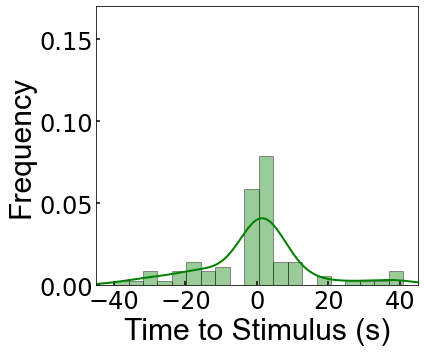

In [10]:
# Density Plot and Histogram of all arrival delays
fig, ax1 = plt.subplots(figsize=(6,5))
ax1.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='24')

sns.distplot(all_responses_LOD, hist=True, kde=True, 
             bins=20, color = 'green', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

ax1.set_xlim(-45, 45)
ax1.set_ylim(0, 0.17)
ax1.set_xticks([-40, -20, 0, 20, 40])
ax1.set_yticks([0.00, 0.05, 0.10, 0.15])

ax1.set_xlabel('Time to Stimulus (s)', fontname="Arial", fontsize="30")
ax1.set_ylabel('Frequency', fontname="Arial", fontsize="30")

# Save
plt.tight_layout()
plt.savefig('HistogramFastLOD.pdf', format = 'pdf')
plt.show()

[ 4  3  7  7  4  3  4  4  5  2  6 12  2 11  5  3  6]


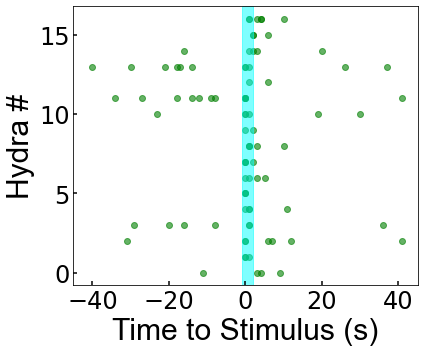

In [11]:
# Scatterplot of time onsets
fig, ax1 = plt.subplots(figsize=(6,5))
ax1.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='24')

index = []
hydraPkCt = hydraPkCt.astype(int)
print(hydraPkCt)
for i in range(0, len(hydraPkCt)):
    for j in range(0, hydraPkCt[i]):
        index = np.append(index, i)
        

ax1.set_xlim(-45, 45)
plt.scatter(all_responses_LOD, index, color='green', alpha=0.6)
ax1.set_xticks([-40, -20, 0, 20, 40])

ax1.set_xlabel('Time to Stimulus (s)', fontname="Arial", fontsize="30")
ax1.set_ylabel('Hydra #', fontname="Arial", fontsize="30")

ax1.axvspan(-1, 2, alpha=0.5, color='cyan')

# Save
plt.tight_layout()
plt.savefig('ScatterplotFastLOD.pdf', format = 'pdf')
plt.show()

/Users/jacobbeckham/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


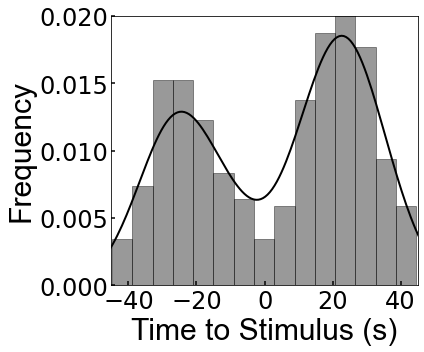

In [12]:
# Density Plot and Histogram of all arrival delays
fig, ax1 = plt.subplots(figsize=(6,5))
ax1.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='24')

all_responses_scipy2 = all_responses_scipy[np.where((all_responses_scipy >= -45) & (all_responses_scipy <=45))]

sns.distplot(all_responses_scipy2, hist=True, kde=True, 
             bins=int(15), color = 'black', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

ax1.set_xlim(-45, 45)
ax1.set_ylim(0, 0.02)
ax1.set_xticks([-40, -20, 0, 20, 40])

ax1.set_xlabel('Time to Stimulus (s)', fontname="Arial", fontsize="30")
ax1.set_ylabel('Frequency', fontname="Arial", fontsize="30")

# Save
plt.tight_layout()
plt.savefig('HistogramSciPy.pdf', format = 'pdf')
plt.show()

[21 27 37 43  6 18 32 35 40  4  8 17 11 22 21  9 26]


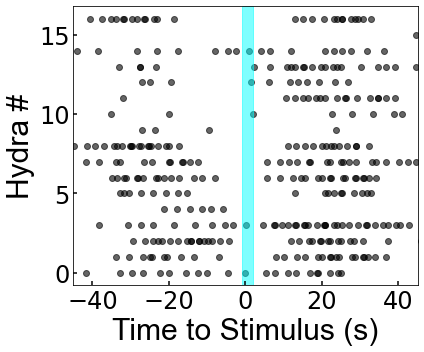

In [13]:
# Scatterplot of time bursts
fig, ax1 = plt.subplots(figsize=(6,5))
ax1.tick_params(direction='in', length=4, width=1.5, colors='black', grid_alpha=0, labelsize='24')

index = []
hydraPkCt2 = hydraPkCt2.astype(int)
print(hydraPkCt2)
for i in range(0, len(hydraPkCt2)):
    for j in range(0, hydraPkCt2[i]):
        index = np.append(index, i)
        

ax1.set_xlim(-45, 45)
plt.scatter(all_responses_scipy, index, color='black', alpha=0.6)
ax1.set_xticks([-40, -20, 0, 20, 40])

ax1.set_xlabel('Time to Stimulus (s)', fontname="Arial", fontsize="30")
ax1.set_ylabel('Hydra #', fontname="Arial", fontsize="30")

ax1.axvspan(-1, 2, alpha=0.5, color='cyan')

# Save
plt.tight_layout()
plt.savefig('ScatterplotFastSciPy.pdf', format = 'pdf')
plt.show()

In [7]:
# Necessary functions for success rate calculations
def get_values(df, i): 
    counter1 = 0
    counter2 = 0
    counter3 = 0
    if df['F0'][i+1] > df['F0'][i]*LODt:
        counter1+=1
        counter2+=1
        counter3+=1
    elif df['F0'][i+2] > df['F0'][i]*LODt:
        counter2+=1
        counter3+=1
    elif df['F0'][i+3] > df['F0'][i]*LODt:
        counter3+=1
    return(counter1, counter2, counter3)

def count_null(df, i): 
    null = 0
    if df['F0'][i] > 0.2: 
        null += 1
    return null

In [8]:
# Define vars
mc1 = 0
mc2 = 0
mc3 = 0
tot_null = 0
tot = len(txt_files)*5
successRates = []

# Process
for j in range(0, len(txt_files)): 
    df = processTrace(txt_files[j])
    stimFrames = [55, 139, 209, 265, 335]
    c1 = 0
    c2 = 0
    c3 = 0
    n=0
    for k in range(0, len(stimFrames)): 
        i = stimFrames[k]
        [counter1, counter2, counter3] = get_values(df, i)
        null = count_null(df, i)
        c1 = c1+counter1
        c2 = c2+counter2
        c3 = c3+counter3
        n = n+null
    if null + c3 > 5:
        null = 5 - c3
    mc1 = mc1+c1
    mc2 = mc2+c2
    mc3 = mc3+c3
    tot_null = tot_null+n
    percent = mc3/(tot - tot_null)*100
    successRate = c3/(5-null)
    successRates = np.append(successRates, [successRate])
    
# Print stuff
print('Within 3 frames: ', mc3)
print('Total shots: ', tot)
print('Total shots while already contracting: ', tot_null)
print('Total percent: ', percent, '%')
print(successRates)
print(np.std(successRates))

Within 3 frames:  48
Total shots:  85
Total shots while already contracting:  14
Total percent:  67.6056338028169 %
[0.  0.8 0.6 0.6 0.6 0.6 0.6 1.  0.6 0.4 0.6 1.  0.4 0.6 0.5 0.4 0.4]
0.22690942967042246


In [9]:
# If the previous script didn't work, this one should! 

mc1 = 0
mc2 = 0
mc3 = 0
tot_null = 0
tot = len(txt_files)*5
hits = []
successRates = []

# Process
for j in range(0, len(txt_files)):
    filename = txt_files[j]
    df = processTrace(filename)
    try: 
        stimFrames = [55, 139, 209, 265, 335]
        c1 = 0
        c2 = 0
        c3 = 0
        n=0
        for k in range(0, len(stimFrames)): 
            i = stimFrames[k]
            [counter1, counter2, counter3] = get_values(df, i)
            null = count_null(df, i)
            c1 = c1+counter1
            c2 = c2+counter2
            c3 = c3+counter3
            n = n+null
        mc1 = mc1+c1
        mc2 = mc2+c2
        mc3 = mc3+c3
        tot_null = tot_null+n
        successRate = c3/(5-null)
        successRates = np.append(successRates, [successRate])
    except:
        print(txt_files[j])
        stimFrames = [56, 84, 126, 154, 182]
        c1 = 0
        c2 = 0
        c3 = 0
        n=0
        for k in range(0, len(stimFrames)): 
            i = stimFrames[k]
            [counter1, counter2, counter3] = get_values(df, i)
            null = count_null(df, i)
            c1 = c1+counter1
            c2 = c2+counter2
            c3 = c3+counter3
            n = n+null
        mc1 = mc1+c1
        mc2 = mc2+c2
        mc3 = mc3+c3
        tot_null = tot_null+n
        successRate = c3/(5-null)
        successRates = np.append(successRates, [successRate])
percent = mc3/(tot - tot_null)*100
successRates = np.asarray(successRates)
successRates = successRates.flatten()
# print(mc1)
# print(mc2)
print('Within 3 frames: ', mc3)
print('Total shots: ', tot)
print('Total shots while already contracting: ', tot_null)
print('Total percent: ', percent, '%')
print(successRates)
print(np.std(successRates))
print('Number of traces: ', len(successRates))

Within 3 frames:  48
Total shots:  85
Total shots while already contracting:  14
Total percent:  67.6056338028169 %
[0.   0.8  0.6  0.6  0.6  0.6  0.6  1.   0.6  0.4  0.6  1.25 0.4  0.6
 0.5  0.4  0.4 ]
0.2599574093409924
Number of traces:  17
